<a href="https://colab.research.google.com/github/sirius59/ART_AI/blob/main/ART_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [ ]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Download the dataset from internet and extract it on the system

NB: replace the link by a new one using this URL in case of an issue like "file is not a zipfile" https://www.mediafire.com/file/v5jpwfjeldhmc8z/dataset_resized.zip/file

In [ ]:
zipurl = 'https://download848.mediafire.com/wqci8ep2zd7g/v5jpwfjeldhmc8z/dataset_resized.zip'
with urlopen(zipurl) as zipresp:
  with ZipFile(BytesIO(zipresp.read())) as zfile:
    zfile.extractall()

Extracting metadata from artist.csv

In [ ]:
artists=pd.read_csv('/content/dataset_resized/artists.csv')

##name of artists
artists['name'][19]='Albrecht_Durer' #fix ASCII problems
tmp=artists['name']
name=[tmp[i].replace(' ','_') for i in range(len(tmp))]#replace space by underscore, more convinent to import images

##genre of artists
tmp=artists['genre']
genre=[tmp[i].replace(',','/') for i in range(len(tmp))]#replace coma by slash, avoid mistakes in list

##number of paintings by artists
nb_paints=artists['paintings']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Labelize a genre with a number

In [ ]:
genre_label={'Expressionism':1,'Abstractionism':2,'Social Realism':3,'Muralism':4,'Impressionism':5,'Surrealism':6,'Byzantine Art':7,'Post-Impressionism':8,'Symbolism':9,'Art Nouveau':10,'Northern Renaissance':11,'Suprematism':12,'Cubism':13,'Baroque':14,'Romanticism':15,'Primitivism':16,'Mannerism':17,'Proto Renaissance':18,'Early Renaissance':19,'High Renaissance':20,'Neoplasticism':21,'Pop Art':22,'Abstract Expressionism':23}
#labelize a genre by a number

Append all artworks in a list

In [ ]:
artworks=[]
for i in range(len(name)):
  for j in range(nb_paints[i]):
    artworks.append(plt.imread(f'/content/dataset_resized/resized/{name[i]}_{j+1}.jpg'))

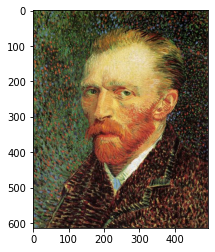

In [ ]:
plt.imshow(artworks[np.random.randint(len(artworks)+1)])

Some utility functions